# Supervisor - Worker Controlled Flow for Gen Pod AI Backend


Let us import some basic libraries and load dotenv file, make sure it contains necessary API keys.

In [1]:
import os
import pprint as pp
from dotenv import load_dotenv

load_dotenv()

True

## Loading LLM
We will load OpenAI GPT-4o LLM to assist our agents.

In [2]:
from langchain_openai import ChatOpenAI
# gpt-4o-2024-05-13

llm = ChatOpenAI(model="gpt-4o-2024-05-13", temperature=0, max_retries=5, streaming=True, seed=4000)
code_llm = ChatOpenAI(model="gpt-4-turbo-2024-04-09",temperature=0.3, max_retries=5, streaming=True, seed=4000)

/home/cravela@appstekcorp.local/Projects/DOUBLE/genpod-ai-backend/.venv/lib/python3.12/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! seed is not default parameter.
                seed was transferred to model_kwargs.
                Please confirm that seed is what you intended.
  warnings.warn(
/home/cravela@appstekcorp.local/Projects/DOUBLE/genpod-ai-backend/.venv/lib/python3.12/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! seed is not default parameter.
                seed was transferred to model_kwargs.
                Please confirm that seed is what you intended.
  warnings.warn(


## Import Modules Needed for this Project

In [3]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser
from langchain.schema import Document
from typing_extensions import TypedDict
from typing import List
# from langgraph.prebuilt import ToolExecutor, ToolInvocation
import json
# from langchain_core.agents import AgentAction, AgentFinish

from langgraph.graph import END, StateGraph

## Let us create some Utility function
These function can help later on to read the input files as a json string and create agents that can be later used as nodes in the graph.

In [4]:
def read_input_json(file_path) -> str:
    """Reads JSON data from a file and returns it as a string.

    Args:
        file_path: The path to the JSON file.

    Returns:
        A string representation of the JSON data.
    """
    with open(file_path, 'r') as user_input_file:
        data = json.load(user_input_file)
    
    user_input = json.dumps(data)
    license_txt = data["LICENSE_TEXT"]

    return user_input, license_txt


## Define tools to be used by Agents
These tools are custom fuctions that will also go as nodes in the graph and will be called by the agent to take some action.

In [5]:
# Update this path to your local directory where you want to create the project at.
PROJECT_PATH = "/home/cravela@appstekcorp.local/Projects/DOUBLE/genpod-ai-backend/output"

In [6]:
from langchain_core.tools import tool, StructuredTool
from typing import Annotated
import os
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool

@tool
def write_generated_code_to_file(
    generated_code: Annotated[str, "The code generated by the agent."],
    file_path: Annotated[str, "Absolute path where the generated code should be written can handle directory create if does not exist."]
    # license_txt: Annotated[str, "License txt provided by user to add to each src file."]
):
# project_folder: Annotated[str, "The name of the project where all files needed for the project are to placed."]
    """
    Writes the provided generated code to the specified file within the project structure.

    Args:
        generated_code (str): The code generated by the agent.
        file_path (str): The path where the generated code should be written.
    """
    try:

        # Ensure the directory exists before writing the file
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        
        with open(file_path, 'w') as file:
            file.write(generated_code)
        
        return {'project_files':file_path}, f"Successfully wrote the generated code to: {file_path}"
    except BaseException as e:
        return f"Failed to write generated code. Error: {repr(e)}"
    

In [7]:
import os
import subprocess
from typing import Annotated
from langchain.tools import tool

@tool
def create_git_repo(project_name: Annotated[str, "Name of the new Git repository that should be created."], repo_path: str) -> dict:
    """
    Creates a new Git repository at the specified path.

    Args:
        project_name (str): Name of the new Git repository that should be created.
        PROJECT_PATH (str): Path where the new Git repository will be created.

    Returns:
        A dictionary containing the path of the newly created Git repository or an error message.
    """
    try:
        repo_path = os.path.join(PROJECT_PATH, project_name)
        
        # Ensure the directory exists before initializing the Git repository
        os.makedirs(repo_path, exist_ok=True)
        
        # check_path = os.path.join(repo_path, ".git")
        # Check if the directory is already a Git repository
        # if os.path.exists(check_path):
        #     return f"Project is already a git repository: {repr(e)}"
        
        subprocess.check_output(['git', 'init'], cwd=repo_path)
        
        return {'repo_path': repo_path}, f"Git repository created successfully: {repo_path}"
    except Exception as e:
        return f"Failed to create a new Git repository. Error: {repr(e)}"


In [8]:
import subprocess
from typing import Annotated
from langchain.tools import tool

ALLOWED_COMMANDS = ['mkdir', 'docker', 'python', 'python3', 'pip', 'virtualenv', 'mv', 'pytest']

@tool
def execute_command(
    command: Annotated[str, "The complete set of commands to be executed on the local machine in order."],
    repo_path: Annotated[str,"Path where the repository is created."]
):
    """
    Executes a command on the local machine.

    Args:
        command (str): The complete set of commands to be executed on the local machine in order.
    """
    # Split the command into parts
    parts = command.split()
    
    # Check if the command is in the whitelist
    if parts[0] not in ALLOWED_COMMANDS:
        return f"Command '{parts[0]}' is not allowed."
    
    try:
        # Execute the command
        # full_path = os.path.join(PROJECT_PATH,repo_path)
        additional_command = f"cd {repo_path} && "
        updated_command = additional_command + command
        result = subprocess.check_output(updated_command, shell=True)
        
        return f"Command executed successfully. Output: {result}"
    except BaseException as e:
        return f"Failed to execute command. Error: {repr(e)}"


In [9]:
import os
from typing import Annotated, List
from langchain.tools import tool

@tool
def check_files_created(
    files: Annotated[List[str], "The list of files that should be present in the project repository."],
    repo_path: Annotated[str, "Absolute Path where the repository is created."]
):
    """
    Checks if all the specified files within a folder structure are created or not.

    Args:
        files (List[str]): The list of files to check.
    """
    missing_files = []
    
    # Check each file
    for file in files:
        full_file_path = os.path.join(repo_path, file)
        
        # Directly check if the file exists without executing shell commands
        if not os.path.exists(full_file_path):
            missing_files.append(file)
    
    if missing_files:
        return {"missing_files":missing_files}, f"missing these files: {missing_files}"
    else:
        return "All files are present."

In [10]:
import os
from typing import Annotated, List
from langchain.tools import tool

@tool
def verify_file_content(
    files: Annotated[List[str], "The list of files that should be present in the project repository."],
    repo_path: Annotated[str, "Absolute Path where the repository is created."]
):
    """
    Checks if all the specified files within a folder structure are empty or not.

    Args:
        files (List[str]): The list of files to check.
    """
    empty_files = []
    
    # Check each file
    for file in files:
        full_file_path = os.path.join(repo_path, file)
        
        # Check if the file exists and is empty
        if os.path.exists(full_file_path) and os.path.getsize(full_file_path) == 0:
            empty_files.append(file)
    
    if empty_files:
        return f"These files are empty: {empty_files}"
    else:
        return "All files are not empty."

In [11]:
import requests
import os
from typing import Annotated

@tool
def download_license_file(
        url: Annotated[str, "LICENSE_URL from where it has to be downloaded."],
        file_path: Annotated[str, "Absolute path where the License.md should be written can handle directory create if does not exist."]
 ) -> str:
    """
    Downloads a license file from a given URL and saves it locally.

    Args:
    url (str): The URL of the license file.
    file_path (str): Absolute path where the generated code should be written can handle directory create if does not exist.
    
    Returns:
    str: The local path where the file was saved.
    """
    import pprint as pp
    response = requests.get(url)
    # print(response.content)
    # response.raise_for_status()  # Raise exception if the request failed
    try:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        with open(file_path, 'wb') as file:
            file.write(response.content)
        return f"Successfully wrote the License to {file_path}"

    except:
        return f"failed to write the License to {file_path}"


## Let's us define a Data model that we can use to update the call's in the graph plus also to define a schema of response from the llm's

In [12]:
from pydantic import BaseModel, Field
from typing import Dict, ClassVar

class RequirementsDoc(BaseModel):
    """Requirements Document output"""

    project_name: str = Field(description="Project name that the user has assigned you to work on", required=True)
    well_documented: str = Field(description="Well built requirements document from the user input", required=True)
    tasks: str = Field(description="Spilt the detailed requirements into independent task with as much context as possible that are crucial to follow during completion", required=True)
    project_folder_structure: str = Field(description="Project folder structure to follow.", required=True)
    next_task: str = Field(description="Next Task to do with all the functional and non functional details related to that task", required=True)
    call_next: str = Field(description="What to do next", required=True)
    task_status: str = Field(description="Current state of the user assigned task. Ex: New, InProgress, Done", required=True)

    # deliverables: Dict[str, str] = Field(default_factory=dict, description="A seperate Dictionary of Tasks and their corresponding details for completion", required=True)
    description: ClassVar[str] = "Schema of what all documents should be generated."


In [13]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import json
architect_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
    
            """<instructions> You are a Development Lead in charge of implementing the given project. Thoroughly analyze the user input and build a thorough requirements document needed to implement the project. 
            You should also be able to break them into independent tasks that can be assigned to other team memeber.\
            Enforce the use of microservice architecture, Best practices Project Folder structure, 12-factor application standards,\
            domain-driven microservice application design, clean-code development architecture standards in the requirements document\
            Final project should include all the source files, configuration files, unit test files, OpenAPI specfile for the project in YAML, License.md file from the User provided URL, a Requirements.txt file, Dockerfile, gitignore and a dockerignore file.
            Structure your answer: 
            1) pick the project name from the user input, 
            2) A well defined complete requirements document, 
            3) Separate the tasks that are required to be completed in the project with all the functional and nonfunctional requirements needed to perform the task smoothly. 
            4) Project_folder_structure to be enforced for the project 
            5) What should be the next task if we decide to start working on the project.\n
            6) Mark the assigned task as NEW when you freshly recieve the task from user and set the call_next to 'Coder'. 
            7) Mark the assigned task as DONE when coder has completed all the assigned tasks and set the call_next to '__end__'.
            Invoke the RequirementsDoc tool to structure the output correctly. </instructions> \n Here is the user question:"""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# First lets read in the input that defines the task to be performed by the multi agent setup
user_input, license_text = read_input_json("rest_api.json")
architect_llm = llm.with_structured_output(RequirementsDoc, include_raw=True)

architect_chain = architect_prompt | llm.with_structured_output(RequirementsDoc, include_raw=True)
question = f"Let's build this Project, here are the user requirements {user_input}."

/home/cravela@appstekcorp.local/Projects/DOUBLE/genpod-ai-backend/.venv/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The method `ChatOpenAI.with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [14]:
question = f"Let's build this Project, here are the user requirements {user_input}."
solution = architect_chain.invoke({"messages":[("user",question)]})
solution


{'raw': AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_VXUDWzF2TPG0rjtrkKo9qRde', 'function': {'arguments': '{"project_name":"user-service","well_documented":"# Project Name: user-service\\n\\n## 1. Introduction\\nThe `user-service` project aims to create a REST API service using Python and FastAPI. The service will manage user data and will be instrumented with the latest version of the OpenTelemetry SDK to send observability data to an OpenTelemetry collector agent.\\n\\n## 2. Functional Requirements\\n\\n### 2.1 REST API Endpoints\\n\\n#### 2.1.1 User Resource\\n- **POST /users**: Create a new user.\\n- **GET /users**: List all users.\\n- **GET /users/{id}**: Get a user by ID.\\n- **PUT /users/{id}**: Update a user by ID.\\n- **DELETE /users/{id}**: Delete a user by ID.\\n\\n### 2.2 Data Model\\n- **User**\\n  - **Name**: string\\n  - **City**: string\\n\\n### 2.3 Database\\n- Use MySQL as the database.\\n\\n### 2.4 Observability\\n- Instrument the 

In [16]:
pp.pp(solution['parsed'])

{'project_name': 'user-service',
 'well_documented': '# Project Name: user-service\n'
                    '\n'
                    '## 1. Introduction\n'
                    'The `user-service` project aims to create a REST API '
                    'service using Python and FastAPI. The service will manage '
                    'user data and will be instrumented with the latest '
                    'version of the OpenTelemetry SDK to send observability '
                    'data to an OpenTelemetry collector agent.\n'
                    '\n'
                    '## 2. Functional Requirements\n'
                    '\n'
                    '### 2.1 REST API Endpoints\n'
                    '\n'
                    '#### 2.1.1 User Resource\n'
                    '- **POST /users**: Create a new user.\n'
                    '- **GET /users**: List all users.\n'
                    '- **GET /users/{id}**: Get a user by ID.\n'
                    '- **PUT /users/{id}**: Update a user

## Now that Architect Chain is ready we can start creating the Coder chain that can be used by the coder agent to complete the task

In [17]:
# First we define a coder model so that we can access ti during our agent node execution.

from pydantic import BaseModel, Field
from typing import ClassVar

class CoderModel(BaseModel):
    """Coder agent output"""

    steps_to_complete: str = Field(description="If the task cannot be completed in one step and needs external tool", required=True)
    files_to_create: str = Field(description="What all files needs to be created", required=True)
    file_path: str = Field(description="Depending on the project structure where should the code be written to", required=True)
    code: str = Field(description="Fully complete, well documented code, with all the naming standards followed that is needed to complete the task.", required=True)
    license_text: str = Field(description="A Licensing text from the user input that needs to be prefixed to each code.", required=True)
    task_completion: str = Field(description="If the assigned task is completed or not", required=True)
    call_next: str = Field(description="What to do next", required=True)
    
    # deliverables: Dict[str, str] = Field(default_factory=dict, description="A seperate Dictionary of Tasks and their corresponding details for completion")
    description: ClassVar[str] = "Schema of task completion output from Coder."

In [18]:
coder_tools = ["write_generated_code_to_file", "create_git_repo", "execute_command", "download_license_file"]

## We May need to create args Schema for each of the other tool as well, if we want to attach all of them to the coder llm.
Let us first create for the three below, we can create for others later on

In [19]:
from pydantic import BaseModel, Field

class WriteGeneratedCodeToFileSchema(BaseModel):
    generated_code: str = Field(description="The code generated by the agent.", required=True)
    file_path: str = Field(description="Absolute path where the generated code should be written.", required=True)

class CreateGitRepoSchema(BaseModel):
    project_name: str = Field(description="Name of the new Git repository that should be created.", required=True)
    repo_path: str = Field(description="Path where the new Git repository will be created.", required=True)

class ExecuteCommandSchema(BaseModel):
    command: str = Field(description="The complete set of commands to be executed on the local machine in order.", required=True)
    repo_path: str = Field(description="Path where the repository is created.", required=True)


Now we can create the tools dict() that can be binded with the coder llm using with_structured_output() `This approach did not work`

In [20]:
from langchain.tools import StructuredTool

tools_dict = {
    "write_generated_code_to_file": write_generated_code_to_file,
    "create_git_repo": create_git_repo,
    "execute_command": execute_command,
    "download_license_file": download_license_file,
    "CoderModel": CoderModel,
    # "write_generated_code_to_file": StructuredTool.from_function(write_generated_code_to_file),
    # "write_generated_code_to_file": StructuredTool(
    #     name="write_generated_code_to_file",
    #     description="Writes the provided generated code to the specified file.",
    #     args_schema=WriteGeneratedCodeToFileSchema,
    #     func=write_generated_code_to_file
    # ),
    # "create_git_repo": StructuredTool(
    #     name="create_git_repo",
    #     description="Creates a new Git repository at the specified path.",
    #     args_schema=CreateGitRepoSchema,
    #     func=create_git_repo
    # ),
    # "execute_command": StructuredTool(
    #     name="execute_command",
    #     description="Executes a command on the local machine.",
    #     args_schema=ExecuteCommandSchema,
    #     func=execute_command
    # ),
    # "CoderModel": StructuredTool(
    #     name="CoderModel",
    #     description="Coder agent output",
    #     args_schema=CoderModel,  # Directly using the Pydantic model
    #     func=None  # No function associated; it's just a schema
    # )
}

## Tool Node

In [21]:
from langgraph.prebuilt import ToolNode

coder_tools_list = [write_generated_code_to_file, create_git_repo, execute_command, download_license_file]
coder_tool_node = ToolNode(coder_tools_list)

In [22]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import json
Coder_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
    
            """<instructions>
            You are an expert programmer collaborating with the Architect in your team to complete an end to end Coding Project.
            You are good at writing well documented, optimized, secure and productionizable code.
            Here are the standards that you need to follow explicitly for this project:
            1. You do not assume anything and asks Architect for additional context and clarification if requirements are not clear.
            2. Must follow Project Folder Structure decided by Architect.
            3. Must Write the files to the local filesystem.
            4. Follow microservices development standards like 12-factor application standards, domain-driven microservice architecture and clean-code development architecture standards.

            Structure your answer: 
            1) Multiple steps may be needed to complete this task that needs access to some external tools {coder_tools}, if so add these steps and mark the task_completion as InComplete and call_next to call_tool.
            2) Depending on the project structure where should the code be written to, 
            3) Fully complete, well documented code, with all the naming standards to follow, that is needed to complete the task., 
            4) A Licensing text from the user input that needs to be prefixed to each code. 
            5) Mark the assigned task as COMPLETED and set the call_next to 'Architect', only after receiving the confirmation from one of the external tools. 
            6) Mark the assigned task as INCOMPLETE and set the call_next to 'call_tool'\n
            Invoke the CoderModel tool to structure the output correctly. </instructions> \n Here is the Architect task:"""
        ),
        MessagesPlaceholder(variable_name="coder_tools"),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

print(solution['parsed'].keys())

# First lets read in the input that defines the task to be performed by the multi agent setup
architect_input = solution['parsed']['next_task']
print(architect_input)

Coder_llm = code_llm.with_structured_output(CoderModel, include_raw=True)

coder_chain = Coder_prompt | Coder_llm
question = f"Here is a task for you to complete {architect_input}. "

dict_keys(['project_name', 'well_documented', 'tasks', 'project_folder_structure', 'next_task', 'call_next', 'task_status'])
The next task is to set up the project structure and initialize a new FastAPI project.


In [23]:
coder_response = coder_chain.invoke({"context":solution["parsed"]['project_folder_structure'] + license_text, "coder_tools": coder_tools, "messages":[("user",question)]})

In [24]:
pp.pp(coder_response)

{'raw': AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_qmdSmVc0NgxU5TC9zXvJp44D', 'function': {'arguments': '{"steps_to_complete":"1. Download the license file to include in the project files. 2. Create a new Git repository for the project. 3. Write the generated FastAPI project code to the local filesystem.","files_to_create":"main.py, __init__.py, requirements.txt","file_path":"/src/app","code":"# License text will be added here\\n\\nfrom fastapi import FastAPI\\n\\napp = FastAPI()\\n\\n@app.get(\\"/\\")\\ndef hello_world():\\n    return {\\"message\\": \\"Hello World\\"}","license_text":"Please provide the license text to be included in the project files.","task_completion":"INCOMPLETE","call_next":"call_tool"}', 'name': 'CoderModel'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'stop'}, id='run-b0714236-6613-4405-9437-2c9fa0fb1ac1-0', tool_calls=[{'name': 'CoderModel', 'args': {'steps_to_complete': '1. Download the license file to in

## Coder binded with tools

In [25]:
Coder_with_tools_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",

            # TODO: need to rephrase this properly
            """<instructions> 
            You are an expert programmer collaborating with the Coder in your team to complete an end to end coding project.
            You are good at picking the right tools for the task finished by Coder.
            Here are the standards that you need to follow explicitly for this project:
            1. You are not supposed to change the anything thats generated by coder.
            2. Must follow Project Folder Structure decided by Architect.
            3. Must Write the files to the local filesystem.
            4. Must pick the right tools to complete the task of the coder.

            Structure your answer:
            1) Multiple steps may be needed to complete this task that needs access to some external tools {coder_tools}, if so pick the proper tool to complete the task.
            2) Depending on the project structure where should the code be written to. 
            </instructions>
            Here is the Coders Solution:
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="coder_tools"),
    ]
)

Coder_llm_with_tools = code_llm.bind_tools(coder_tools_list)

coder_with_tools_chain = Coder_with_tools_prompt | Coder_llm_with_tools
ct_question = f"Here is a task for you to complete {coder_response['parsed']}. "

In [26]:
coder_tools_response = coder_with_tools_chain.invoke({"context":solution["parsed"]['project_folder_structure'] + license_text, "coder_tools": coder_tools, "messages": [("user", ct_question)]})
pp.pp(coder_tools_response)

AIMessage(content='To complete the task as per the requirements, we\'ll need to:\n\n1. Download the license file.\n2. Create a new Git repository for the project.\n3. Write the generated FastAPI project code to the local filesystem at the specified path.\n\nHere\'s the plan:\n\n- **Step 1:** Download the license file to `/src/app/LICENSE.md`.\n- **Step 2:** Create a new Git repository in the `/src/app` directory.\n- **Step 3:** Write the generated FastAPI project code to `/src/app/main.py`.\n\nLet\'s execute these steps using the appropriate tools:\n\n1. **Download License File:** We will use the `download_license_file` function to download the license file to `/src/app/LICENSE.md`.\n2. **Create Git Repository:** We will use the `create_git_repo` function to create a new repository named "FastAPI_Project" at `/src/app`.\n3. **Write Generated Code:** We will use the `write_generated_code_to_file` function to write the FastAPI code to `/src/app/main.py`.\n\nWe will execute these steps in

## Let's Define a New State that will maintain all the statespace needed to run the architect coder flow smoothly.

In [27]:
import operator
from typing import Annotated, Sequence, TypedDict
from typing_extensions import TypedDict, List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int
    project_name: Annotated[str, "Project name that the user has assigned to work on"]
    requirements_overview: Annotated[str, "Well built requirements document from the user input"]
    tasks: Annotated[str, "Spilt the detailed requirements into independent task with as much context as possible that are crucial to follow during completion"]
    project_folder_structure: Annotated[str, "Project folder structure to follow."]
    next_task: Annotated[str, "Next Task to do with all the functional and non functional details related to that task"]
    file_path: Annotated[str, "Depending on the project structure where should the code be written to", operator.add]
    code: Annotated[str, "Fully complete, well documented code, with all the naming standards followed that is needed to complete the task.", operator.add]
    license_text: Annotated[str, "A Licensing text from the user input that needs to be prefixed to each code."]
    task_completion: Annotated[str, "If the assigned task is completed or not"]
    call_next: Annotated[str, "Whom to call next"]
    

In [28]:
from operator import itemgetter
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langgraph.prebuilt import ToolExecutor, ToolInvocation, ToolNode

def Architect(state: GraphState):
    print("----Architect Started to Work on the Project----")
    
    # Let's Grab important information from the state
    messages = state['messages']
    error = state['error']
    iteration = state['iterations']

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the Requirements_Doc tool to structure the output with a project_name, well_documented, tasks, project_folder_structure and next_task",
            )
        ]
    
    architect_solution = architect_chain.invoke({'messages':messages})

    # Check if any fields in the schema are missing values.
    missing_keys = []
    for key in RequirementsDoc.__annotations__:
        if key != 'description' and key not in architect_solution['parsed']:
            missing_keys.append(key)
    
    if architect_solution['parsing_error']:
        raw_output = architect_solution['raw']
        error = architect_solution['parsing_error']
        messages += [
            (
                "user",
                f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parse error: {error}"
            )
        ]

    elif missing_keys:
        messages += [
            (
                "user",
                f"Now, try again. Invoke the RequirementsDoc tool to structure the output with a project_name, well_documented, tasks, project_folder_structure and next_task, you missed {missing_keys} in your previous response",
            )
        ]
    else:
        state['next_task'] = messages['parsed']['next_task']
        state['project_name'] = messages['parsed']['project_name']
        state['requirements_overview'] = messages['parsed']['well_documented']
        state['tasks'] = messages['parsed']['tasks']
        state['project_folder_structure'] = messages['parsed']['project_folder_structure']
        state['call_next'] = messages['parsed']['call_next']

        messages += [
            (
                "assistant",
                "Well document requirements is present now. see what task needs to be completed and do that now.",
            )
        ]

    # We can keep track of this so that architect agent does not get stuck in a loop
    iteration += 1
    return {'messages': messages, 'iterations': iteration, **state}

def architect_router(state: GraphState):
    
    return state['call_next']
    

In [29]:
from operator import itemgetter
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langgraph.prebuilt import ToolExecutor, ToolInvocation, ToolNode

def Coder(state: GraphState):
    print("----Coder Started to Work on the Task assigned----")

    # Initial setup
    messages = state['messages']
    error = state['error']
    iteration = state['iterations']
    next_task = state['next_task']
    question = f"Here is a task for you to complete {next_task}. "
    context = state['project_folder_structure'] + license_text


    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again." # TODO: Need to work on this scenario
            )
        ]
    
    coder_solution = coder_chain.invoke({"context": context, "coder_tools": coder_tools, "messages": [("user", question)]}) # need to handle error scenatrio from above.

    missing_keys = []
    for key in CoderModel.__annotations__:
        if key != 'description' and key not in coder_solution['parsed']:
            missing_keys.append(key)
    
    if coder_solution['parsing_error']:
        raw_output = coder_solution['raw']
        error = coder_solution['parsing_error']
        messages += [
            (
                "user",
                f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parse error: {error}"
            )
        ]
    elif missing_keys:
        messages += [
            (
                "user",
                f"Now, try again. Invoke the CoderModel tool to structure the output with a steps_to_complete, files_to_create, file_path, code, license_text, task_completion and call_next. you missed {missing_keys} in your previous response"
            )
        ]
    else:
        state['file_path'] = messages['parsed']['file_path']
        state['code'] = messages['parsed']['code']
        state['license_text'] = messages['parsed']['license_text']
        state['task_completion'] = messages['parsed']['task_completion']
        state['call_next'] = messages['parsed']['call_next']
        
        messages += [
            (
                "assistant",
                "Coder has completed the task assigned. Assign him the next task if any."
            )
        ]
    
    # TODO: Implement a termination criteria, if you read through the prompt I was planning to make use of the 'task_completion' and 'call_next' fields
    # TODO: Invoke the coder_chain with values similar to the usage in one of the above sample cells. This will explicitly define steps that needs to be done. You may need you own utility function to parse through the responses to `response['parsed'][key] for key in keys`
    # TODO: Create a new chain to which you can bind the tools that can be called and that way you may not need a router and just loop between that llm_with_tool_chain and the coder_chain. \
    #       Otherwise you will need to create three different nodes that can call one of the tool_function\
    #       and use a router to call one of those tool node by passing the state. 
    # TODO: Create a langgraph, compile it and run it to test the flow.
    # Note: Keep in you can always add more values to the state if needed and update the state values by returning a dictionary consisting of keys same as in Graphstate. 
    
    iteration += 1
    return {'messages': messages, 'iterations': iteration, **state}


def coder_router(state: GraphState):
    """
    Defines which path need to be taken from coder node.
    """
    task_status = state['task_completion'] # INCOMPLETE, COMPLETED
    next = state['call_next'] # Architect, call_tool

    return next



## Need for Persistence
In LangGraph, memory for maintaining context across interactions is facilitated via Checkpointers within StateGraphs.  
1. When setting up a LangGraph workflow, you can ensure state persistence by employing a Checkpointer like `AsyncSqliteSaver`.  
2. Simply include this in your workflow setup by calling `compile(checkpointer=my_checkpointer)` during graph compilation.

In [30]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

### Controlled Graph Flow

In [31]:
workflow = StateGraph(GraphState)

workflow.add_node("Architect", Architect)
workflow.add_node("Coder", Coder)
# workflow.add_node("call_tool", CoderTools)

workflow.add_conditional_edges("Architect", architect_router,
    {
        "Coder": "Coder",
        END: END
    }
)
workflow.add_conditional_edges("Coder", coder_router,
    {
        "Coder": "Coder",
        "Architect": "Architect",
        # "call_tool": "call_tool"
    }
)

workflow.set_entry_point("Architect")

workflow_graph = workflow.compile(checkpointer=memory)

## Workflow call graph

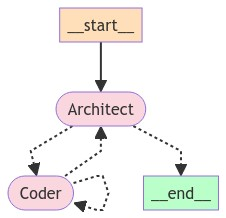

In [32]:
from IPython.display import Image, display

try:
    display(Image(workflow_graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## If you want to add MISMO Documents from the URL, you can use something like this for now, Remember this approach is very expensive and will consume thousands of tokens.

In [ ]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# MISMO docs
url = "LINK TO MISMO DOCS URL"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)


# You then pass `concatenated_content` as context to architect chain later on by doing something like this
# solution = architect_chain.invoke({"context": concatenated_content, "messages":[("user",question)]})